In [1]:
# imports

import os 
import math
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt


# methods

'''
Map each letter to a number in the range 0-25 (26 letters in total).
'''
def letter2num(letter):
    return int(ord(letter) - 65)

'''
Add +1 column for the bias. Not used in the last version.
'''
def add_bias_input(X):
    bias_array = np.ones(len(X))
    X = np.c_[X,bias_array]
    return X

'''
Shuffle the data.
'''
def shuffle_data(X, y,features):
    data_table = np.c_[X,y]
    np.random.shuffle(data_table)
    return data_table[:,:features], data_table[:,features]

'''
Split the data of a given table (input or output) into training and testing sets considering a fraction.
'''
def train_test_split(table,fraction):
    train_size = len(table) * fraction
    train_size = math.floor(train_size)
    test_size = train_size + 1
    return table[:test_size], table[test_size:]

'''
Create numpy array (either 1d or 2d) and fill it with NaNs.
'''
def create_array(dim1, dim2):
    if dim2 != 0:   # 2d
        arr=np.empty((dim1,dim2))
    else:           # 1d
        arr=np.empty(dim1)
    arr.fill(np.NaN)
    return arr

'''
Sigmoid activation function.
'''
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

'''
Apply the forward pass: find the values of the neurons using the dot product. 
'''
def forward_phase(x_array, row, numLayers):
    if numLayers == 4:
        for i in range(numHid1):
            nodesHid1_values[i] = sigmoid(np.dot(x_array[row,:],in2hid_weights[:,i]) + hid1_biases[i])
        for i in range(numHid2):
            nodesHid2_values[i] = sigmoid(np.dot(nodesHid1_values[:],hid2hid_weights[:,i]) + hid2_biases[i])
        for i in range(numOutput):
            nodesOut_values[i] = sigmoid(np.dot(nodesHid2_values[:],hid2out_weights[:,i]) + out_biases[i])

    if numLayers == 3:
        for i in range(numHid1):
            nodesHid1_values[i] = sigmoid(np.dot(x_array[row,:],in2hid_weights[:,i]) + hid1_biases[i])
        for i in range(numOutput):
            nodesOut_values[i] = sigmoid(np.dot(nodesHid1_values[:],hid2out_weights[:,i]) + out_biases[i])

'''
Return 1 if the current image is classified correctly.
'''
def calculate_success(target_values):
    if target_values[np.argmax(nodesOut_values)] == 1:
        return 1
    return 0

'''
Return "cost" of the current image to find Mean Square Error in the end of the epoch.
'''
def calculate_error(target_values):
    return sum(np.square(nodesOut_values - target_values))

def make_target_values(row, table):
    arr=np.zeros(26)
    arr[int(table[row])] = 1
    return arr

'''
Update weights using the negative gradient to minimize the error.
'''
def backward_phase(row, target_values):
    # step 1. find the partial derivatives (direction: backwards)
    global nodesOut_deriv
    nodesOut_deriv = nodesOut_values - target_values

    for z in range(nodesHid2_deriv.shape[0]):
        nodesHid2_deriv[z] = 0
        for w in range(numOutput):
            nodesHid2_deriv[z] = nodesHid2_deriv[z] + (hid2out_weights[z][w] * nodesOut_values[w] * (1-nodesOut_values[w]) * nodesOut_deriv[w])

    for z in range(nodesHid1_deriv.shape[0]):
        nodesHid1_deriv[z] = 0
        for w in range(numHid2):
            nodesHid1_deriv[z] = nodesHid1_deriv[z] + (hid2hid_weights[z][w] * nodesHid2_values[w] * (1-nodesHid2_values[w]) * nodesHid2_deriv[w])

    # step 2. update weights and biases (direction: forward - but it does not matter since we have computed all the partial derivates until now)
    for i in range(in2hid_weights.shape[0]):
        for j in range(in2hid_weights.shape[1]):
            tmp = in2hid_weights[i][j]
            in2hid_weights[i][j] = in2hid_weights[i][j] - learning_rate * (X_train[row][i] * nodesHid1_values[j] * (1-nodesHid1_values[j]) * nodesHid1_deriv[j]) + momentum * (in2hid_weights[i][j] - in2hid_oldweights[i][j])
            in2hid_oldweights[i][j] = tmp
    for k in range(len(hid1_biases)):
        tmp_b = hid1_biases[k]
        hid1_biases[k] = hid1_biases[k] - learning_rate * (1 * nodesHid1_values[k] * (1-nodesHid1_values[k]) * nodesHid1_deriv[k]) + momentum * (hid1_biases[k] - hid1_oldbiases[k])
        hid1_oldbiases[k] = tmp_b
        
    for i in range(hid2hid_weights.shape[0]):
        for j in range(hid2hid_weights.shape[1]):
            tmp = hid2hid_weights[i][j]
            hid2hid_weights[i][j] = hid2hid_weights[i][j] - learning_rate * (nodesHid1_values[i] * nodesHid2_values[j] * (1-nodesHid2_values[j]) * nodesHid2_deriv[j]) + momentum * (hid2hid_weights[i][j] - hid2hid_oldweights[i][j])
            hid2hid_oldweights[i][j] = tmp
    for k in range(len(hid2_biases)):
        tmp_b = hid2_biases[k]
        hid2_biases[k] = hid2_biases[k] - learning_rate * (1 * nodesHid2_values[k] * (1-nodesHid2_values[k]) * nodesHid2_deriv[k]) + momentum * (hid2_biases[k] - hid2_oldbiases[k])
        hid2_oldbiases[k] = tmp_b

    for i in range(hid2out_weights.shape[0]):
        for j in range(hid2out_weights.shape[1]):
            tmp = hid2out_weights[i][j]
            hid2out_weights[i][j] = hid2out_weights[i][j] - learning_rate * (nodesHid2_values[i] * nodesOut_values[j] * (1-nodesOut_values[j]) * nodesOut_deriv[j]) + momentum * (hid2out_weights[i][j] - hid2out_oldweights[i][j])
            hid2out_oldweights[i][j] = tmp
    for k in range(len(out_biases)):
        tmp_b = out_biases[k]
        out_biases[k] = out_biases[k] - learning_rate * (1 * nodesOut_values[k] * (1-nodesOut_values[k]) * nodesOut_deriv[k]) + momentum * (out_biases[k] - out_oldbiases[k])
        out_oldbiases[k] = tmp_b

'''
Vizualize a monitored metric.
'''
def vizual(metric, label):
    plt.plot(metric)

    plt.xlabel("EPOCHS")
    plt.ylabel(label)
    plt.title('{} over the EPOCHS'.format(label))
    plt.show()

In [2]:
X = list()
y = list()

# load the data
file = open(os.path.dirname(os.path.abspath("__file__")) + '/datasets/problem2_data.txt')
for line in file.readlines():
    vector = line.split(',')

    y.append(letter2num(vector[0]))
    current_list = list()
    for i in range(1,len(vector)):
        num = int(vector[i].replace('\n', ''))
        num = num / 15.0    # scaling
        current_list.append(num)
    X.append(current_list)
file.close()

np.random.seed(10)

X = np.array(X)

# shuffle the data
features = X.shape[1]
X, y = shuffle_data(X, y,features)

# split to train and test sets
fraction = 0.7
X_train, X_test = train_test_split(X,fraction)
y_train, y_test = train_test_split(y,fraction)

In [3]:
# Neural network constants

numInput = features
numHid1 = 60
numHid2 = 50
numOutput = 26 # letters of english alphabet
numLayers = 4
if numLayers == 3:      # make numHid2 equal to numHid1 and ignore weights between them, derivatives and values
    numHid2 = numHid1

learning_rate = 0.9
epochs = 200
momentum = 0.1

# weights
# in2hid_weights = np.random.rand(numInput,numHid1)
# hid2out_weights = np.random.rand(numHid2,numOutput)
in2hid_weights = np.random.uniform(low=-1,high=1,size=(numInput,numHid1))
hid2out_weights = np.random.uniform(low=-1,high=1,size=(numHid2,numOutput))

# biases
hid1_biases = np.random.uniform(low=-1,high=1,size=numHid1)
out_biases = np.random.uniform(low=-1,high=1,size=numOutput)

# old weights and biases
in2hid_oldweights = np.copy(in2hid_weights)
hid2out_oldweights = np.copy(hid2out_weights) 
hid1_oldbiases = np.copy(hid1_biases)  
out_oldbiases = np.copy(out_biases)  

# values
nodesHid1_values = create_array(dim1=numHid1,dim2=0)
nodesOut_values = create_array(dim1=numOutput,dim2=0)

# derivatives
nodesHid1_deriv = create_array(dim1=numHid1,dim2=0)
nodesOut_deriv = create_array(dim1=numOutput,dim2=0)

if numLayers == 4:
    # hid2hid_weights = np.random.rand(numHid1,numHid2)
    hid2hid_weights = np.random.uniform(low=-1,high=1,size=(numHid1,numHid2))
    hid2_biases = np.random.uniform(low=-1,high=1,size=numHid2)
    hid2hid_oldweights = np.copy(hid2hid_weights)
    hid2_oldbiases = np.copy(hid2_biases)
    nodesHid2_values = create_array(dim1=numHid2,dim2=0)
    nodesHid2_deriv = create_array(dim1=numHid2,dim2=0)

In [5]:
success_list = list()
mse_list = list()
counter = 0
learning_rate = 0.4

for ep in tqdm(range(epochs)):

    epoch_success = 0
    epoch_mse = 0

    for row in range(X_train.shape[0]):

        # forward phase
        forward_phase(X_train, row, numLayers)

        # calculate success and error
        target_values = make_target_values(row, y_train)
        epoch_success += calculate_success(target_values)
        epoch_mse += calculate_error(target_values)

        # backward phase
        backward_phase(row, target_values)
        # counter += 1
        # if counter % 4 == 0:
        #     backward_phase(row, target_values)

    epoch_mse = epoch_mse / X_train.shape[0]

    success_list.append(epoch_success)
    mse_list.append(epoch_mse)

    print('EPOCH: {} | SUCCESS: {} - {}% | MSE: {}'.format(ep, epoch_success, epoch_success/X_train.shape[0], epoch_mse))

  0%|          | 1/200 [04:27<14:47:07, 267.47s/it]

EPOCH: 0 | SUCCESS: 12810 - 0.9149346475251767% | MSE: 0.10561251058919127


  1%|          | 2/200 [09:15<15:22:16, 279.48s/it]

EPOCH: 1 | SUCCESS: 12833 - 0.9165773873294765% | MSE: 0.0995001482567451


  2%|▏         | 3/200 [13:15<14:18:56, 261.61s/it]

EPOCH: 2 | SUCCESS: 12831 - 0.9164345403899722% | MSE: 0.09730493798845553


  2%|▏         | 4/200 [17:17<13:48:34, 253.65s/it]

EPOCH: 3 | SUCCESS: 12842 - 0.9172201985572459% | MSE: 0.09652903152379727


  2%|▎         | 5/200 [21:18<13:30:31, 249.39s/it]

EPOCH: 4 | SUCCESS: 12845 - 0.9174344689665024% | MSE: 0.09532579443589127


  2%|▎         | 5/200 [24:54<16:11:09, 298.82s/it]


KeyboardInterrupt: 

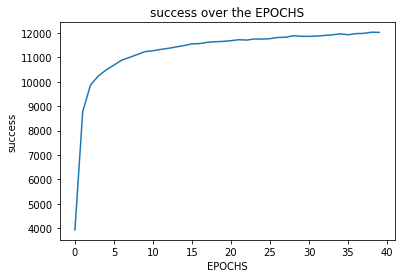

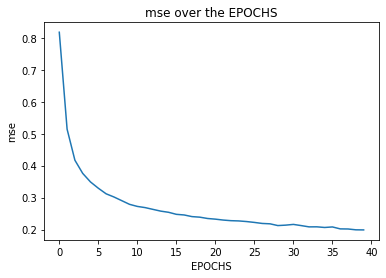

In [5]:
vizual(success_list,'success')
vizual(mse_list,'mse')

In [6]:
test_success = 0
test_mse = 0
for row in range(X_test.shape[0]):

    # forward phase
    forward_phase(X_test, row, numLayers)

    # calculate success and error
    target_values = make_target_values(row, y_test)
    test_success += calculate_success(target_values)
    test_mse += calculate_error(target_values)

test_mse = test_mse / X_test.shape[0]

print('During testing: ')
print('MSE : ', test_mse)
print('Success: {} (out of {})'.format(test_success,X_test.shape[0]))

During testing: 
MSE :  0.23630122898315317
Success: 4996 (out of 5999)
